In [458]:
import pandas as pd
import numpy as np
import nltk
import requests
import re
import json
import random
import scipy

import geopandas

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [2]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
occupations = gc.open_by_url("https://docs.google.com/spreadsheets/d/1nONTEwp42CVnq3iCiONrFbJedIcYtBV-l4Bil5mU7Eo/edit?usp=sharing")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [3]:
# login to our project folder
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [481]:
# read the datasets
publicfolder = "e0f9cd400dd05584fe06fe1d804deff0"
EDH = sddk.read_file("EDH_urban_context.json", "df", publicfolder) # data with urban_context column
# EDH = sddk.read_file("EDH_occupsorgs_2021-02-26.json", "df", publicfolder)
EDCS = sddk.read_file("EDCS_occupsorgs_2021-02-26.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


In [223]:
# read and execute our script for modelling dates - TEMPUN
script_url = "https://raw.githubusercontent.com/sdam-au/tempun/master/scripts/modelling_distributions.py"
# execute the script
exec(requests.get(script_url).content)

In [482]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
EDH["random_dates"] = EDH.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)
# EDCS["random_dates"] = EDCS.apply(lambda row: model_date(row["dating from"], row["dating to"], size=1000,), axis=1)

CPU times: user 26.3 s, sys: 374 ms, total: 26.7 s
Wall time: 26.7 s


In [45]:
%%time
EDH_complete_simulations = timeblocks_from_randoms(EDH, "random_dates", [-200, 600, 50])

CPU times: user 3.13 s, sys: 7.81 ms, total: 3.14 s
Wall time: 3.14 s


In [186]:
EDH_complete_simulations[0]

[((-200, -151), 33),
 ((-150, -101), 72),
 ((-100, -51), 227),
 ((-50, -1), 1071),
 ((1, 50), 4916),
 ((51, 100), 6725),
 ((101, 150), 10709),
 ((151, 200), 12821),
 ((201, 250), 11548),
 ((251, 300), 6082),
 ((301, 350), 1680),
 ((351, 400), 1353),
 ((401, 450), 740),
 ((451, 500), 607),
 ((501, 550), 419),
 ((551, 600), 423)]

In [ ]:
def simulations_merged(simulation_data):
    merged_data = []
    for n in range(len(simulation_data[0])): # choose the first simulation to get the length 
        merged_data.append((simulation_data[0][n][0], [sim[n][1] for sim in simulation_data]))
    return merged_data

ED_merged = simulations_merged(occups_ins_ratio)
orgs_ratios_merged = simulations_merged(orgs_ins_ratio)

In [310]:
EDH_complete_merged = simulations_merged(EDH_complete_simulations)

# Comparing distributions by means of KDE

In [332]:
var_data = []
for var_n in range(1000):
    var_data.append([var[var_n] for var in EDH["random_dates"] if var !=None])

In [308]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudians" : {"startdate": -27, "enddate" : 67},
    "Flavians" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 193},
    # or:
    #"5 good emperors" : {"startdate": 97, "enddate": 180},
    #"Commodus" : {"startdate" : 181, "enddate" : 193},
    "Severan dynasty" : {"startdate": 194, "enddate": 235},
    "Crisis of the 3rd\nCentury" : {"startdate" : 236, "enddate" : 284},
    "Diocetian\n& Constantine" : {"startdate" : 285, "enddate" : 337}
    }
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 67), (69, 96), (97, 193), (194, 235), (236, 284), (285, 337)]

CPU times: user 1min 19s, sys: 1min 40s, total: 3min
Wall time: 24.2 s


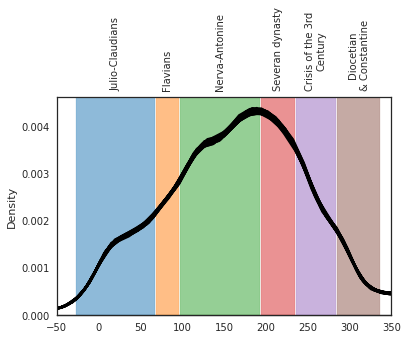

In [335]:
%%time 
# timeconsuming, because of the KDE involved
labels=[key for key in periods.keys()]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[6,4])

for data in var_data[:100]:
    sns.kdeplot(data, ax=ax, color="black")
for period, color in zip(periods.keys(), tab_colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color, alpha=0.5)#, linestyles="dashed", color="red")
ax.set_xlim(-50,350)


# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")

# Spatial dissemination of inscriptions

In [483]:
# EDH as a geodataframe
EDHg = EDH[EDH["coordinates"].apply(lambda x: isinstance(x, list))]
EDHg = geopandas.GeoDataFrame(EDHg, geometry=geopandas.points_from_xy(EDHg["coordinates"].apply(lambda x: x[0]), EDHg["coordinates"].apply(lambda x: x[1])), crs={"init": "epsg:3857"})

/home/kasev/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [484]:
def get_date_var(randoms):
    try: return randoms[0]
    except: return None
EDHg["date_var_1"] = EDHg["random_dates"].apply(get_date_var)

In [485]:
def date_to_str(date):
    if date < 0:
        date = str(abs(date)) + "BC"
    else: 
        date = str(date) + "AD"
    return date

periods_labels = []
for period in periods.keys():
    start = date_to_str(periods[period]["startdate"])
    end = date_to_str(periods[period]["enddate"])
    periods_labels.append(period + " ({0}-{1})".format(start, end))
periods_labels

['Julio-Claudians (27BC-67AD)',
 'Flavians (69AD-96AD)',
 'Nerva-Antonine (97AD-193AD)',
 'Severan dynasty (194AD-235AD)',
 'Crisis of the 3rd\nCentury (236AD-284AD)',
 'Diocetian\n& Constantine (285AD-337AD)']

In [486]:
### # pelagios provinces - only for plotting purposes
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = geopandas.read_file(url, crs={"init": "epsg:3857"})
pleiades_regions.head()

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."


In [492]:
%%time
# usually time consumming => apply carefully
RE_polygon = pleiades_regions.unary_union
print("length before: ", len(EDHg))
EDHg = EDHg[EDHg.within(RE_polygon)]
print("length after: ", len(EDHg))

length before:  79012
length after:  74404
CPU times: user 6min 35s, sys: 120 µs, total: 6min 35s
Wall time: 6min 35s


In [495]:
df_by_periods = []
for period in timeblocks_periods:
    sample = EDHg[EDHg["date_var_1"].between(period[0], period[1])]
    df_by_periods.append(sample)

In [496]:
for context, color in [("rest", "darkgreen"), ("middle", "darkred"), ("big", "darkblue")]:
    print(context)

rest
middle
big


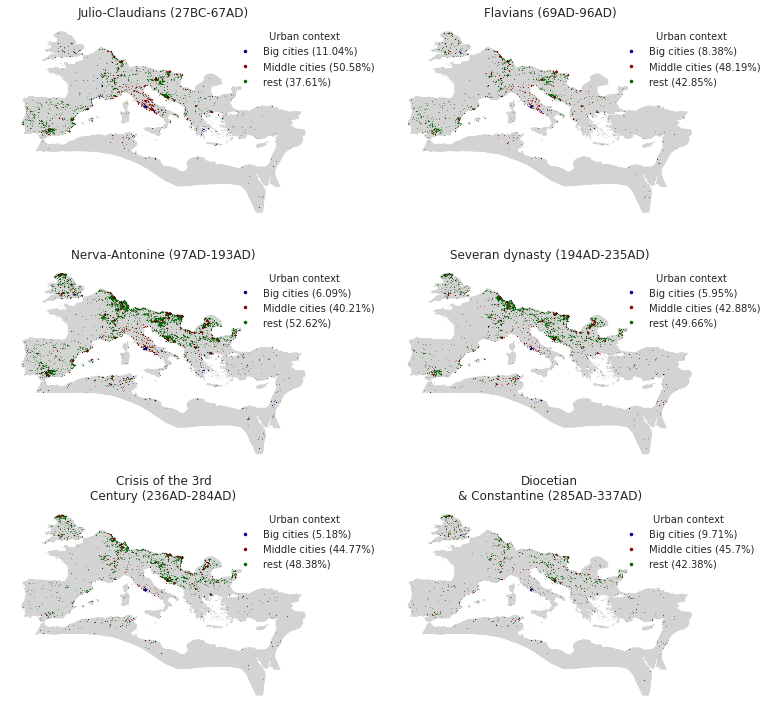

In [505]:
fig, axs  = plt.subplots(3, 2, figsize=(12, 10), tight_layout=True)

contexts_pct = {}

for df, ax, period in zip(df_by_periods, axs.ravel(), periods_labels):
    pleiades_regions.plot(ax=ax, color="lightgray")
    for context, color in [("rest", "darkgreen"), ("middle", "darkred"), ("big", "darkblue")]:
        df_context = df[df["urban_context"]==context]
        contexts_pct[context] = str(np.round(((len(df_context) / len(df)) * 100), 2)) + "%"
        df_context.plot(markersize=0.6, color=color, alpha=0.4, ax=ax)
    ax.set_title(period)
    ax.set_axis_off()
    markers = [plt.Line2D([0,0],[0,0],color=color, marker=".", linestyle="") for color in ["darkblue", "darkred", "darkgreen"]]
    legend_labels = ["Big cities ({0})".format(contexts_pct["big"]), "Middle cities ({0})".format(contexts_pct["middle"]), "rest ({0})".format(contexts_pct["rest"])]
    ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(0.7, 1), loc='upper left')

In [506]:
date_vars_by_context = []
for context in ["big", "middle", "rest"]:
    subset_df = EDH[EDH["urban_context"]==context]
    date_vars = []
    for n in range(100):
        date_vars.append([date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_context.append(date_vars)

In [512]:
lengths = []
for context in ["big", "middle", "rest"]:
    lengths.append(len(EDHg[EDHg["urban_context"]==context]))
lengths

[8620, 32228, 32460]

CPU times: user 2min 20s, sys: 3min 20s, total: 5min 41s
Wall time: 31.3 s


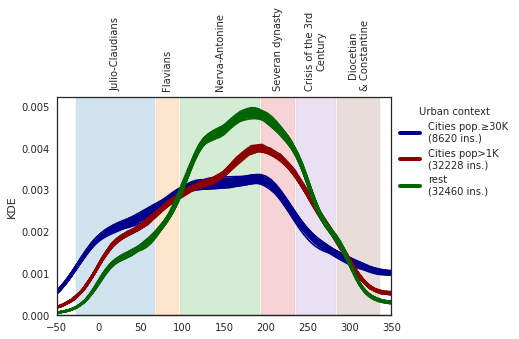

In [519]:
%%time 
# timeconsuming, because of the KDE involved
labels=[key for key in periods.keys()]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[6,4])

labels_ins = [tup[0] for tup in simulations_by_type_len]

for period, color in zip(periods.keys(), tab_colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color, alpha=0.2)#, linestyles="dashed", color="red")

for context_data, color in zip(date_vars_by_context, ["darkblue", "darkred", "darkgreen"]):
    for sim_var in context_data:
        sns.kdeplot(sim_var, ax=ax, color=color)
        

ax.set_xlim(-50,350)
ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")

lengths = []
for context in ["big", "middle", "rest"]:
    lengths.append(len(EDHg[EDHg["urban_context"]==context]))

markers = [plt.Line2D([0,0],[0,0],color=color, linewidth=4) for color in ["darkblue", "darkred", "darkgreen"]]
legend_labels = ["Cities pop.≥30K\n({0} ins.)".format(str(lengths[0])), "Cities pop>1K\n({0} ins.)".format(str(lengths[1])), "rest\n({0} ins.)".format(str(lengths[2]))]
plt.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 1), loc='upper left')

# Occupations and organizations over time

In [349]:
var_data_occups, var_data_orgs = [], []
for var_n in range(1000):
    var_data_occups.append([var[var_n] for var in EDH[EDH["occups_N"] > 0]["random_dates"] if var !=None])
    var_data_orgs.append([var[var_n] for var in EDH[EDH["organizations_N"] > 0]["random_dates"] if var !=None])

In [396]:
len(EDH[(EDH["occups_N"] > 0) & (EDH["random_dates"].notnull())])

1224

In [397]:
print(len(var_data_occups[0]))
print(len(var_data_orgs[0]))

1224
529


In [399]:
sample_size = len(var_data_occups[0]) + len(var_data_orgs[0])
sample_size

1753

CPU times: user 3.32 s, sys: 81.8 ms, total: 3.4 s
Wall time: 3.23 s


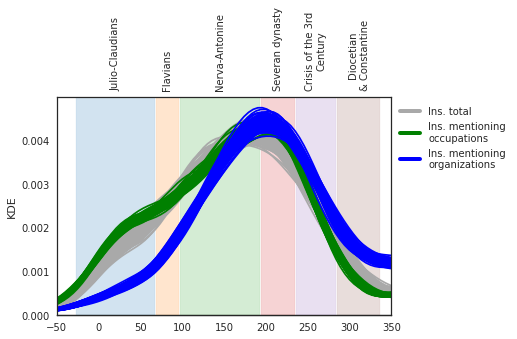

In [412]:
%%time 
# timeconsuming, because of the KDE involved
labels=[key for key in periods.keys()]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[6,4])

for period, color in zip(periods.keys(), tab_colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color, alpha=0.2)#, linestyles="dashed", color="red")


for data in var_data[:100]:
    # to be based on sample or not... 
    data = random.sample(data, k=sample_size)
    sns.kdeplot(data, ax=ax, color="darkgrey", alpha=0.5)   
    
for data in var_data_occups[:100]:
    sns.kdeplot(data, ax=ax, color="green", alpha=0.5)
    
for data in var_data_orgs[:100]:
    sns.kdeplot(data, ax=ax, color="blue", alpha=0.5)
 

    
ax.set_xlim(-50,350)



ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")


markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["darkgrey", "green", "blue"]]
plt.legend(markers, ["Ins. total", "Ins. mentioning\noccupations", "Ins. mentioning\norganizations"], bbox_to_anchor=(1, 1), loc='upper left')


# Statistical comparison


We use two-sample Kolmogorov-Smirnov test, which checks whether  two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal).  

We employ it to compare distribution of all iscriptions mentioning an occupation/organization against a distribution based on a random sample of inscriptions of the same length. We repeat this procedure for all dating simulations and evaluate the consinstency of the findings.

In [431]:
# one variant example
scipy.stats.kstest(var_data_orgs[0], random.sample(var_data[0], k=len(var_data_orgs[0])))

KstestResult(statistic=0.1833648393194707, pvalue=3.4677011823818415e-08)

In [438]:
random.seed(0)

p_values, KS_stats = [], []
for var_n in range(len(var_data)):
    ks, p = scipy.stats.ks_2samp(var_data_orgs[var_n], random.sample(var_data[var_n], k=len(var_data_orgs[var_n])))
    KS_stats.append(ks)
    p_values.append(p)
len([p for p in p_values if p < 0.001])

998

In the case of organizations, there is a robust difference in the distributions, with p < 0.001 in more than 99% of cases.

In [444]:
random.seed(0)

p_values, KS_stats = [], []
for var_n in range(len(var_data)):
    ks, p = scipy.stats.ks_2samp(var_data_occups[var_n], random.sample(var_data[var_n], k=len(var_data_occups[var_n])))
    KS_stats.append(ks)
    p_values.append(p)
len([p for p in p_values if p < 0.001])

35

In [445]:
len([p for p in p_values if p < 0.05])

619

In the case of occuptions, the difference is much smaller, with p<0.05 in only about 62% of cases.

In [446]:
# counts on the basis of periods
EDH_complete_periods = timeblocks_from_randoms(EDH, "random_dates", timeblocks_periods)
EDH_complete_periods[0]

[((-27, 67), 7690),
 ((69, 96), 4137),
 ((97, 193), 22235),
 ((194, 235), 10351),
 ((236, 284), 7446),
 ((285, 337), 3074)]

# Inscriptions over time: Word counts & character counts

In [7]:
# functions to be used to extract interesting information from timeblocks simulation data

def wordcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()

def wordcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum() / len(timeblock_df)

def charcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()

def charcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum() / len(timeblock_df)

def unique_words(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock"""
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words

def unique_words_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock
    in proportion to total number of words"""
    wordcount = timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words / wordcount

def extract_ngrams(text, width=4):
    """extracts character ngrams from a string of given width
    returns: list of ngrams"""
    char_ngrams = ["".join(ngram) for ngram in list(ngrams(str(text), width))]
    return char_ngrams

def unique_ngrams(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique)

def unique_ngrams_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock
    in proportion to total number of characters"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique) / charcount

In [8]:
%%time
wordcounts_data = sim_data_by_function(EDH, 100, [-200, 600, 50], wordcount) 
wordcounts_avg_data = sim_data_by_function(EDH, 100, [-200, 600, 50], wordcount_avg) 
charcounts_data = sim_data_by_function(EDH, 100, [-200, 600, 50], charcount) 
charcounts_avg_data = sim_data_by_function(EDH, 100, [-200, 600, 50], charcount_avg) 
unique_words_data = sim_data_by_function(EDH, 100, [-200, 600, 50], unique_words)
unique_ngrams_data = sim_data_by_function(EDH, 100, [-200, 600, 50], unique_ngrams)

CPU times: user 6min 57s, sys: 7.72 s, total: 7min 4s
Wall time: 6min 54s


In [57]:
sim_data_list = [
    (EDH_complete_simulations, "(A) EDH - inscription counts", "count"),
    (wordcounts_data, "(B) EDH - wordcounts", "wordcount"),
    (charcounts_data,  "(C) EDH - character counts", "character count"),
    (unique_words_data, "(D) EDH - unique words counts", "count"),
    (unique_ngrams_data, "(E) EDH - unique character four-grams", "count"),
    (charcounts_avg_data, "(F) EDH - average character counts per inscription", "avr. char. count")]
    #(wordcounts_avg_data, "(E) EDH - average wordcounts per inscription", "avr. wordcount"),



In [58]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
tab_colors_list

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

[-5000.0, 0.0, 5000.0, 10000.0, 15000.0]
[-50000.0, 0.0, 50000.0, 100000.0, 150000.0, 200000.0]
[-500000.0, 0.0, 500000.0, 1000000.0, 1500000.0]
[-10000.0, 0.0, 10000.0, 20000.0, 30000.0]
[0.0, 20000.0, 40000.0, 60000.0]


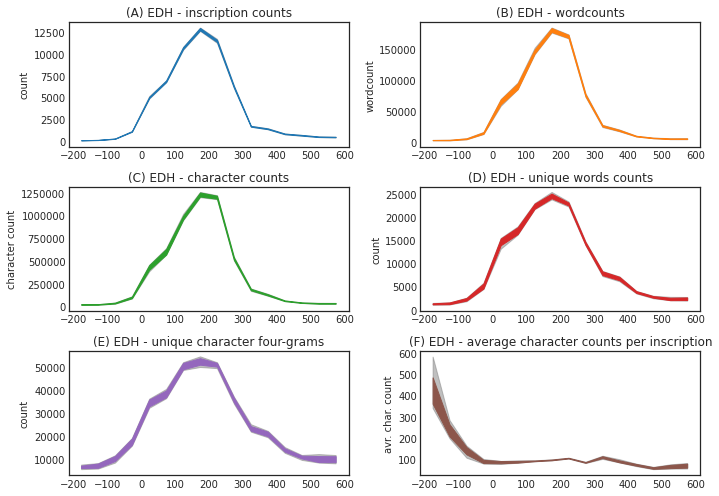

In [60]:
plt.style.use("seaborn-white")

mpl.rcParams["axes.formatter.limits"] = [-5, 10]

fig, axs  = plt.subplots(3, 2, figsize=(10, 7), tight_layout=True)

for sim_data, ax, color in zip(sim_data_list, axs.ravel(), tab_colors_list[:len(sim_data_list)]):
    plot_timeblocks_data(sim_data[0], ax, color)
    ax.set_title(sim_data[1])
    ax.set_ylabel(sim_data[2])
    if max([el[1] for el in sim_data[0][0]]) > 5000:
        ticks = list(ax.get_yticks())
        print(ticks)
        ticks_K = [str(int(int(tick) / 1000)) + "K" if tick != 0 else tick for tick in ticks]
        #ax.set_yticklabels(ticks_K)
# to hide an axis:
#axs[3,1].set_axis_off()       

In [49]:
sddk.write_file("SDAM_data/social_diversity/EDH_word+char_counts_temporal.png", fig, conf)

A file with the same name ("EDH_word+char_counts_temporal.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_word+char_counts_temporal.png"


In [150]:
EDH["language"].unique()

array(['Latin', 'Greek-Latin', 'Greek', 'Phonician-Punic-Latin',
       'Italic-Latin', 'Hebrew-Latin', 'PyGL', 'Celtic-Latin',
       'Iberian-Latin', 'Greek-Hebrew-Latin', 'Hebrew-Iberian-Latin',
       'Palmyrenic-Latin', None, 'Numidian', 'LG', 'Celtic'], dtype=object)

In [148]:
EDH[EDH["language"].str.contains("Latin", na=False)]

,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,geography,social_economic_legal_history,military,occups,occups_N,organizations,organizations_N,random_dates,occupsorgs,occupsorgs_N
0,Feraudi,epitaph,3.2-2 cm,0130,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",provisional,33 cm,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"[{'name': 'Noniae P.f. Optatae', 'cognomen': '...",2.7 cm,...,None,None,None,[],0,[],0,"[124, 74, 106, 77, 72, 106, 96, 74, 100, 102, ...",[],0
1,Feraudi,epitaph,4 cm,0200,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",None,...,None,None,None,[],0,[],0,"[165, 173, 130, 98, 177, 83, 136, 166, 151, 14...",[],0
2,Feraudi,honorific inscription,4.5-3 cm,0170,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",provisional,(37) cm,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"[{'nomen': 'Mummius+', 'gender': 'male', 'prae...",(12) cm,...,None,None,None,[],0,[],0,"[163, 142, 169, 158, 137, 136, 164, 134, 147, ...",[],0
3,Gräf,votive inscription,2.5 cm,0200,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",checked with photo,(39) cm,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,[{'name': '[---?]AV(?)S(?)[---]L(?)L(?)A M. Po...,18 cm,...,None,None,None,[],0,[],0,"[153, 198, 163, 176, 158, 195, 157, 166, 165, ...",[],0
4,Feraudi,epitaph,None,0200,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",no image,None,[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"[{'person_id': '1', 'name': '[---]l. Successus...",None,...,None,None,None,[],0,[],0,"[13, 160, 13, 184, 171, 104, 197, 140, 163, 2,...",[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81471,Feraudi,None,None,0200,"H. Lehner, Die antiken Steindenkmäler des Prov...",checked with drawing,(23) cm,] AEL[ ] / [ ]PRI[ ] / [ ]MAT[,{},11 cm,...,None,None,None,[],0,[],0,"[171, 145, 200, 134, 184, 169, 139, 164, 197, ...",[],0
81472,Feraudi,None,None,0300,"H. Lehner, Die antiken Steindenkmäler des Prov...",checked with drawing,(17) cm,]ON SE[ ] / [ ]IL FRV[ ],{},5.5 cm,...,None,None,None,[],0,[],0,"[256, 241, 235, 164, 67, 65, 235, 278, 154, 22...",[],0
81473,Feraudi,votive inscription,None,0300,"CIL 13, 07788; Zeichnung.; H. Lehner, Die anti...",checked with photo,(21) cm,[ ] / [ ]ABVS / [ ]VS L / [ ]NIVS IV / [ ] COS...,"[{'person_id': '1', 'cognomen': 'Iucundus+?', ...",(11) cm,...,None,None,None,[],0,[],0,"[233, 181, 206, 265, 276, 160, 222, 198, 229, ...",[],0
81474,Gräf,votive inscription?,None,0222,"AE 2006, 0854.; CIL 13, 05940.; A. Daguet-Gage...",provisional,None,None,{},None,...,None,None,None,[],0,[],0,"[185, 216, 215, 212, 193, 217, 208, 206, 184, ...",[],0


In [136]:
def filter_by_first(random_dates):
    try:
        return random_dates[0]
    except:
        None

EDH_100bc = EDH[EDH["random_dates"].apply(filter_by_first) < -100]
EDH_100bc

,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,geography,social_economic_legal_history,military,occups,occups_N,organizations,organizations_N,random_dates,occupsorgs,occupsorgs_N
556,Feraudi,owner/artist inscription,1.6-2.3 cm,-0101,"AE 1983, 0145.; Z. Mari, Tibur, Forma Italiae,...",provisional,None,Q PANDVSINVS,"[{'name': 'Q. Pandusinus', 'nomen': 'Pandusinu...",3.4 cm,...,None,None,None,[],0,[],0,"[-118, -117, -105, -121, -104, -130, -101, -12...",[],0
701,Gräf,votive inscription,None,-0201,"AE 1983, 0405.; A.M. Sgubini Moretti, in: Nuov...",no image,9 cm,[ ]RCIVS L L / [ ]ONEAE / [ ],"[{'person_id': '1', 'name': '[---]rcius l.l.',...",None,...,None,None,None,[],0,[],0,"[-241, -233, -237, -234, -228, -220, -242, -23...",[],0
704,Gräf,votive inscription,None,-0201,"AE 1983, 0408.; A.M. Sgubini Moretti, in: Nuov...",checked with photo,(4.9) cm,] / FERONEA DONO / LVBENS MERTO / DEDIT,"[{'name': 'Feronea', 'nomen': 'Feronea', 'pers...",3.8 cm,...,None,None,None,[],0,[],0,"[-274, -209, -243, -231, -225, -298, -299, -21...",[],0
707,Feraudi,votive inscription,None,-0211,"AE 1983, 0406.; A.M. Sgubini Moretti, in: Nuov...",provisional,9 cm,L CALPVRNIVS / [ ]RONEA DONO MERITE,"[{'nomen': 'Calpurnius', 'name': 'L. Calpurniu...",20 cm,...,None,None,None,[],0,[],0,"[-237, -282, -220, -223, -240, -226, -222, -24...",[],0
865,Gräf,list,1.2-0.8 cm,-0031,"AE 1983, 0389.; M.G. Angeli Bertinelli, QuadSt...",checked with photo,7.5 cm,P [ ]IRTIVS T F / P CVRFIDIVS [ ] / M FVFICIVS...,"[{'name': 'P. [H]irtius T.f.', 'nomen': 'Hirti...",10 cm,...,None,None,None,[],0,[],0,"[-142, -82, -132, -67, -128, -117, -61, -80, -...",[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64708,Cimarosti,votive inscription,4-3.5 cm,None,"CIL 05, 07213.; ILS 1853.; P. Wuilleumier, L’a...",checked through autopsy,63.3 cm,PVDENS SOC / PVBL XL SER / SCR FINIB / COTTI V...,"[{'name': 'Pudens', 'person_id': '1', 'status'...",39 cm,...,data available,data available,None,"[arcarius, arcarius]",2,[],0,"[-177, -170, -167, -165, -151, -169, -176, -15...","[arcarius, arcarius]",2
67256,Gräf,owner/artist inscription,None,None,"AE 2006, 0814.; L. Benquet, Aquitania 22, 2006...",provisional,None,F / M / M AEMILIO / L AVRELIO / COS,"[{'praenomen': 'M.', 'person_id': '1', 'name':...",None,...,None,None,None,[],0,[],0,"[-123, -100, -73, -87, -111, -105, -73, -118, ...",[],0
67351,Cowey,private legal inscription,5 cm,-0171,"IG 11, 04, 00712.; AE 2009, 1308.",no image,54 cm,ΕΔΟΞΕΝ ΤΕΙ ΒΟΥΛΕΙ ΚΑΙ ΤΩΙ ΔΗΜΩΙ· Α[ ] / ΤΙΛΑΚΟ...,"[{'person_id': '1', 'cognomen': 'á¼Î½Ïá½·Î»Î...",9 cm,...,None,None,None,[],0,[],0,"[-184, -182, -197, -178, -196, -175, -188, -17...",[],0
67388,Gräf,list?,None,-0051,"CIL 03, 00714.; CIL 01 (2. Aufl.) 02, 00664.; ...",no image,None,] / C L LVCCI C F EQ / C MISPIVS MVSTE / [,"[{'person_id': '1', 'praenomen': 'C.', 'nomen'...",None,...,None,None,None,[],0,[],0,"[-150, -61, -190, -156, -134, -73, -74, -88, -...",[],0


In [141]:
EDH_100bc["length"] = EDH_100bc["clean_text_interpretive_word"].apply(len)
EDH_100bc.sort_values("length", ascending=False)

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,social_economic_legal_history,military,occups,occups_N,organizations,organizations_N,random_dates,occupsorgs,occupsorgs_N,length
42924,Cowey,public legal inscription,None,-0190,"SIG (3. Aufl.) 609-610.; R.K. Shark, Roman Doc...",no image,None,[ ]ΤΑ ΥΠΑΡΧ[ ]Ν [ ]ΑΛΥΜΑ ΤΟΙΣ ΗΜΕΤΕΡΟΙ[ ]ΙΤΑ[ ...,{},None,...,None,None,[],0,[],0,"[-190, -190, -190, -191, -190, -190, -191, -19...",[],0,4095
53168,Cowey,honorific inscription,None,-0130,"AE 1995, 1377.; K. Gallis, AD 31 B, 1976, 262-...",checked with photo,(130) cm,[ ] / [ ]ΙΑΙ[ ] / [ ]ΣΠΕΠΟ[ ] / [ ]ΗΣ ΑΥΤΟΙΣ[ ...,"[{'nomen': 'ÎÎ±Î¹Îºá½³Î»Î¹Î¿Ï', 'gender': 'm...",10 cm,...,None,None,[],0,[],0,"[-147, -135, -135, -149, -139, -142, -146, -14...",[],0,3651
64381,Cowey,public legal inscription,None,-0167,"AE 2006, 1260.; A. Tziaphalias - J.L. GarcÃ­a ...",checked with photo,93.5 cm,ΤΑΓΕΥΟΝΤΟΥΝ ΤΙΜΟΣΘΕΝΕΟΣ ΑΛΕΞΙΑΙΟΙ ΙΠ / ΠΟΛΟΧΟΙ...,{},12 cm,...,None,None,[],0,[],0,"[-167, -167, -167, -167, -167, -167, -168, -16...",[],0,2413
64370,Cowey,list,1.5-1 cm,-0001,"AE 2005, 1357.; L.D. Loukopoulou - A. Zournatz...",checked with photo,123 cm,ΕΠΙ ΑΡΧΙΕΡΕΩΣ ΤΟΥ ΣΕΡΑΠΙΔΟΣ ΚΑΙ ΤΗΣ / ΕΙΣΙΔΟΣ ...,[{'name': 'ÎÎµÎ½Î¿ÎºÏá½·ÏÎ¿Ï ÏÎ¿á¿¦ ÎÎ·Î...,18 cm,...,None,None,[],0,[],0,"[-102, -150, -117, -95, -141, -21, -22, -105, ...",[],0,1505
64338,Cowey,honorific inscription,0.7-2 cm,-0150,"IG 09, 02, 01292.; IG 09, 02, 01293a.; IG 09, ...",checked with photo,(39) cm,[ ]ΓΟΥΝΤΟΣ ΦΙΛΟΞΕΝΟΥ ΤΟΥ ΕΥΑΡΧ[ ]Υ ΜΟΝΔΑΙΕΩΣ /...,"[{'origo': 'ÎÎ¿Î½Î´Î±Î¹á½³ÏÏ', 'person_id':...",22 cm,...,None,None,[],0,[],0,"[-151, -161, -150, -171, -155, -150, -163, -16...",[],0,1406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13842,Gräf,epitaph,1.8-2.2 cm,-0051,"AE 1968, 0181a.; M. Cristofani, SE 35, 1967, 5...",checked with photo,21 cm,[ ] GREBO [ ],"[{'cognomen': '[---]', 'name': '[---] Grebo [-...",None,...,None,None,[],0,[],0,"[-277, -81, -259, -144, -295, -151, -166, -205...",[],0,5
48723,Gräf,owner/artist inscription,None,-0101,"AE 1998, 1224e.; B. Dautaj, Iliria 24, 1994, 1...",checked with photo,None,CAAC,{},None,...,None,None,[],0,[],0,"[-183, -102, -122, -131, -115, -155, -159, -15...",[],0,4
48728,Gräf,owner/artist inscription,None,-0101,"AE 1998, 1224j.; B. Dautaj, Iliria 24, 1994, 1...",checked with photo,None,OMIT,{},None,...,None,None,[],0,[],0,"[-198, -184, -163, -184, -189, -185, -119, -15...",[],0,4
50047,Platz,owner/artist inscription,None,-0071,"AE 1996, 1635.",provisional,None,L,{},None,...,None,None,[],0,[],0,"[-120, -99, -86, -125, -73, -73, -72, -100, -9...",[],0,4


In [142]:
EDH_100bc.columns

Index(['responsible_individual', 'type_of_inscription', 'letter_size',
       'not_after', 'literature', 'work_status', 'height', 'diplomatic_text',
       'people', 'depth', 'material', 'type_of_monument', 'province_label',
       'width', 'transcription', 'country', 'uri', 'findspot_ancient',
       'last_update', 'modern_region', 'findspot_modern', 'language', 'id',
       'edh_geography_uri', 'commentary', 'trismegistos_uri', 'not_before',
       'external_image_uris', 'fotos', 'coordinates', 'idno_tm',
       'placenames_refs', 'text_edition', 'origdate_text', 'layout_execution',
       'layout_execution_text', 'support_objecttype',
       'support_objecttype_text', 'support_material', 'support_material_text',
       'support_decoration', 'keywords_term', 'keywords_term_text',
       'type_of_inscription_clean', 'type_of_inscription_certainty',
       'height_cm', 'width_cm', 'depth_cm', 'material_clean',
       'type_of_monument_clean', 'type_of_monument_certainty',
       'provi

In [140]:
EDH_100bc.sort_values("length", ascending=False)["id"].tolist()

['HD043295',
 'HD053580',
 'HD065228',
 'HD065217',
 'HD065185',
 'HD044444',
 'HD065235',
 'HD037104',
 'HD065234',
 'HD053732',
 'HD021778',
 'HD022400',
 'HD065233',
 'HD068210',
 'HD065187',
 'HD044493',
 'HD065236',
 'HD056666',
 'HD065230',
 'HD056977',
 'HD056638',
 'HD065232',
 'HD020426',
 'HD056788',
 'HD017681',
 'HD056785',
 'HD065201',
 'HD004004',
 'HD002003',
 'HD065139',
 'HD065555',
 'HD002680',
 'HD056798',
 'HD022784',
 'HD043660',
 'HD036894',
 'HD003965',
 'HD020429',
 'HD029508',
 'HD028716',
 'HD003815',
 'HD023606',
 'HD068269',
 'HD004469',
 'HD000869',
 'HD036967',
 'HD051027',
 'HD001118',
 'HD003556',
 'HD000884',
 'HD037876',
 'HD055621',
 'HD011513',
 'HD015667',
 'HD046201',
 'HD004234',
 'HD016038',
 'HD001109',
 'HD003562',
 'HD002650',
 'HD013960',
 'HD018347',
 'HD014984',
 'HD068247',
 'HD068115',
 'HD013963',
 'HD008472',
 'HD001651',
 'HD002893',
 'HD004064',
 'HD000881',
 'HD040884',
 'HD001877',
 'HD043625',
 'HD003362',
 'HD002950',
 'HD003365',

In [144]:
EDH_100bc.sort_values("length", ascending=False)["language"].tolist()

['Greek',
 'Greek',
 'Greek',
 'Latin',
 'Greek',
 'Latin',
 'Greek',
 'Greek',
 'Greek',
 'Greek',
 'Latin',
 'Greek-Latin',
 'Greek',
 'Greek',
 'Greek',
 'Greek-Latin',
 'Greek',
 'Latin',
 'Greek',
 'Greek-Latin',
 'Greek-Latin',
 'Greek',
 'Greek-Latin',
 'Greek-Latin',
 'Greek-Latin',
 'Greek-Latin',
 'Greek',
 'Latin',
 'Greek-Latin',
 'Greek',
 'Latin',
 'Latin',
 'Greek-Latin',
 'Greek-Latin',
 'Greek',
 'Greek',
 'Latin',
 'Latin',
 'Greek-Latin',
 'Greek-Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Greek',
 'Greek-Latin',
 'Latin',
 'Latin',
 'Italic-Latin',
 'Latin',
 'Greek-Latin',
 'Greek-Latin',
 'Latin',
 'Greek-Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Greek',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 'Latin',
 

# Inscription types over time

In [34]:
simulations_by_type_len = []

for ins_type in EDH["type_of_inscription_clean"].unique():
    if ins_type != "NULL":
        subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type]
        simulations_by_type_len.append((ins_type, len(subset_df)))
simulations_by_type_len = sorted(simulations_by_type_len, key = lambda x: x[1], reverse=True)
simulations_by_type_len

[('epitaph', 27953),
 ('votive inscription', 14044),
 ('owner/artist inscription', 5185),
 ('honorific inscription', 3999),
 ('building/dedicatory inscription', 3307),
 ('mile-/leaguestone', 1730),
 ('identification inscription', 1574),
 ('acclamation', 533),
 ('military diploma', 500),
 ('list', 360),
 ('defixio', 309),
 ('label', 289),
 ('public legal inscription', 248),
 ('boundary inscription', 246),
 ('elogium', 143),
 ('letter', 121),
 ('seat inscription', 87),
 ('prayer', 56),
 ('private legal inscription', 45),
 ('assignation inscription', 16),
 ('calendar', 14),
 ('adnuntiatio', 3)]

In [35]:
simulations_by_type = []

for ins_type_tup in simulations_by_type_len[:10]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    simulations = timeblocks_from_randoms(subset_df, "random_dates", [-200, 600, 100])
    ins_type_N =len(subset_df)
    simulations_by_type.append([ins_type_tup[0],ins_type_N, simulations]) 
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

In [36]:
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

In [37]:
simulations_by_type[4][1]

3307

In [451]:
date_vars_by_instypes = []
for ins_type_tup in simulations_by_type_len[:10]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    date_vars = []
    for n in range(100):
        date_vars.append([date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 2min 22s, sys: 3min 18s, total: 5min 41s
Wall time: 33.5 s


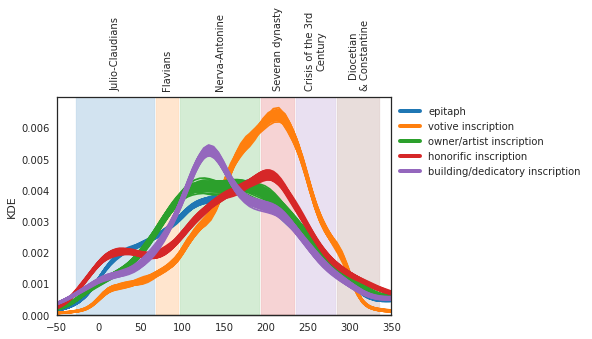

In [457]:
%%time 
# timeconsuming, because of the KDE involved
labels=[key for key in periods.keys()]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[6,4])

labels_ins = [tup[0] for tup in simulations_by_type_len]

for period, color in zip(periods.keys(), tab_colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color, alpha=0.2)#, linestyles="dashed", color="red")

for instype_data, color in zip(date_vars_by_instypes[:5], tab_colors_list[:5]):
    for sim_var in instype_data:
        sns.kdeplot(sim_var, ax=ax, color=color)
        

ax.set_xlim(-50,350)
ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")

markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in tab_colors_list[:len(simulations_by_type)]]
plt.legend(markers, labels_ins[:5], bbox_to_anchor=(1, 1), loc='upper left')


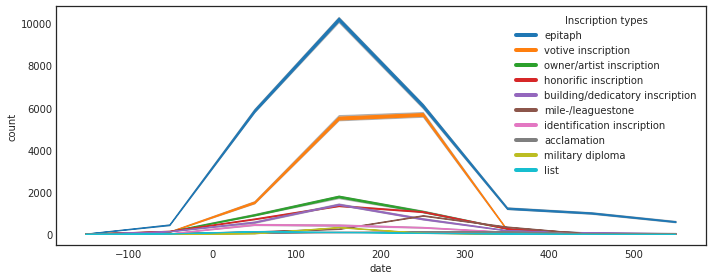

In [40]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax  = plt.subplots(figsize=(10, 4), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type, tab_colors_list[:len(simulations_by_type)]):
    plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)
    
ax.set_xlabel("date")
ax.set_ylabel("count")
#ax.set_title("EDH - 10 most common inscription types over time")
 
markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in tab_colors_list[:len(simulations_by_type)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type], numpoints=1,  title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

In [220]:
sddk.write_file("SDAM_data/social_diversity/EDH_inscription_types_temporal.png", fig, conf)

A file with the same name ("EDH_inscription_types_temporal.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_inscription_types_temporal.png"


# Occupations & organizations over inscription types

In [76]:
# N of occuptions and N of organization per inscription category
ins_types_occs_orgs = []
for ins_type_tup in simulations_by_type_len:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    occ_N = subset_df["occups_N"].sum()
    orgs_N = subset_df["organizations_N"].sum()
    ins_types_occs_orgs.append([ins_type_tup[0] + " (N={0})".format(len(subset_df)), occ_N, orgs_N])
    print("inscription type: {0}, N of occupations: {1}, N of organizations: {2}".format(ins_type_tup[0], str(occ_N), str(orgs_N)))

inscription type: epitaph, N of occupations: 565, N of organizations: 282
inscription type: votive inscription, N of occupations: 345, N of organizations: 150
inscription type: owner/artist inscription, N of occupations: 24, N of organizations: 0
inscription type: honorific inscription, N of occupations: 218, N of organizations: 87
inscription type: building/dedicatory inscription, N of occupations: 103, N of organizations: 48
inscription type: mile-/leaguestone, N of occupations: 0, N of organizations: 0
inscription type: identification inscription, N of occupations: 12, N of organizations: 0
inscription type: acclamation, N of occupations: 5, N of organizations: 0
inscription type: military diploma, N of occupations: 77, N of organizations: 0
inscription type: list, N of occupations: 47, N of organizations: 16
inscription type: defixio, N of occupations: 5, N of organizations: 5
inscription type: label, N of occupations: 0, N of organizations: 0
inscription type: public legal inscrip

In [77]:
pd.DataFrame(ins_types_occs_orgs, columns=["inscription type", "occupations", "organisations"])

,inscription type,occupations,organisations
0,epitaph (N=27953),565,282
1,votive inscription (N=14044),345,150
2,owner/artist inscription (N=5185),24,0
3,honorific inscription (N=3999),218,87
4,building/dedicatory inscription (N=3307),103,48
5,mile-/leaguestone (N=1730),0,0
6,identification inscription (N=1574),12,0
7,acclamation (N=533),5,0
8,military diploma (N=500),77,0
9,list (N=360),47,16


In [51]:
types, occups_freqs, orgs_freqs = [], [], [] 

for ins_type_tup in simulations_by_type_len[:10][::-1]: # for horizontal bar below, we need the list in reverse order, therefore: [::-1]
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    subset_wordcount = wordcount(subset_df).sum()
    types.append(ins_type_tup[0])
    occups_freqs.append(subset_df["occups_N"].sum() / subset_wordcount * 1000)
    orgs_freqs.append(subset_df["organizations_N"].sum() / subset_wordcount * 1000)

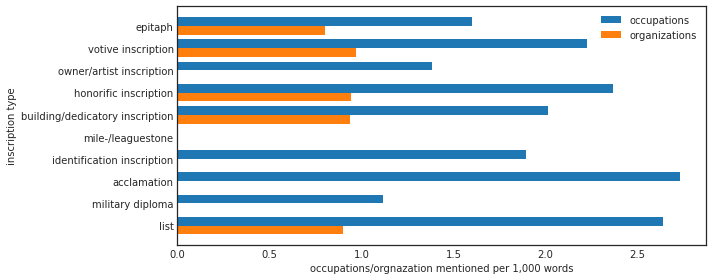

In [52]:
fig, ax  = plt.subplots(figsize=(10, 4), tight_layout=True)

y = np.arange(len(types))
height = 0.4

ax.barh(y + height/2, occups_freqs, height, label="occupations", color="tab:blue") #, color=tab_colors_list[:len(simulations_by_type)])
ax.barh(y - height/2, orgs_freqs, height, label="organizations", color="tab:orange") #, color=tab_colors_list[:len(simulations_by_type)])

ax.set_yticks(y) #y_pos, types)
ax.set_yticklabels(types) #, rotation="vertical")
ax.set_xlabel("occupations/orgnazation mentioned per 1,000 words")
ax.set_ylabel("inscription type")
ax.legend()

In [120]:
sddk.write_file("SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png", fig, conf)

A file with the same name ("EDH_occupsorgs_by_instypes.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png"


# Occupations & organizations together

In [71]:
len(EDH[EDH["organizations_N"]>0])

727

In [72]:
len(EDH[EDH["occups_N"]>0])

1913

In [75]:
len(EDH[(EDH["occups_N"]>0) & (EDH["organizations_N"]>0)])

231

In [76]:
EDH["occupsorgs"] = EDH.apply(lambda row: row["occups"] + row["organizations"], axis=1)

In [77]:
EDH["occupsorgs_N"] = EDH["occupsorgs"].apply(len)

In [78]:
EDH["occupsorgs_N"].sum()

3136

In [79]:
occupsorgs_list = [el for el in EDH["occupsorgs"].tolist() if len(el) > 0]
occupsorgs_list

[['corpus'],
 ['negotiator'],
 ['fullo'],
 ['dendrophorus'],
 ['aerarius', 'corpus'],
 ['mulionus'],
 ['mulionus'],
 ['collegium'],
 ['corpus'],
 ['faber'],
 ['navalis', 'faber', 'corpus'],
 ['subaedianus',
  'subaedianus',
  'faber',
  'faber',
  'collegium',
  'corpus',
  'corpus'],
 ['faber'],
 ['argentarius', 'coactor'],
 ['negotiator'],
 ['negotiator'],
 ['scriba', 'corpus', 'corpus'],
 ['curator'],
 ['corpus'],
 ['pomarius'],
 ['sagittarius', 'sagittarius'],
 ['aerarius'],
 ['curator'],
 ['arcarius'],
 ['curator', 'faber'],
 ['sagittarius', 'faber'],
 ['copo'],
 ['collegium', 'collegium'],
 ['faber', 'collegium'],
 ['sagittarius', 'sagittarius'],
 ['sagittarius', 'sagittarius'],
 ['sagittarius', 'sagittarius'],
 ['sagittarius', 'sagittarius'],
 ['faber'],
 ['imaginarius',
  'scriba',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'collegium',
  'corpus',
  'corp

In [102]:
len(occupsorgs_list)

2409

In [90]:
dictionary = corpora.Dictionary(occupsorgs_list)

In [93]:
dictionary = corpora.Dictionary(occupsorgs_list)
vocabulary = [el[1] for el in dictionary.items()]
vocabulary[:10]

['corpus',
 'negotiator',
 'fullo',
 'dendrophorus',
 'aerarius',
 'mulionus',
 'collegium',
 'faber',
 'navalis',
 'subaedianus']

In [109]:
orgs = ["colegium", "collegium", "collegiatus", "collegius", "collega", "concilium", "conlegium", "collegatarius", "collegiarius", "corpus", "corporatus", "sociatio", "societas", "sodalitas", "sodalicium"]

In [115]:
for org in orgs:
    try:
        org_id = dictionary.token2id[org]
        org_freq = dictionary.cfs[org_id]
        print("'{0}' count: {1}".format(org, org_freq))
    except:
        print("'{0}' not found".format(org))

'colegium' count: 1
'collegium' count: 452
'collegiatus' count: 11
'collegius' count: 10
'collega' count: 60
'concilium' count: 12
'conlegium' count: 13
'collegatarius' not found
'collegiarius' count: 1
'corpus' count: 288
'corporatus' count: 11
'sociatio' not found
'societas' count: 5
'sodalitas' not found
'sodalicium' count: 4


In [106]:
terms_dfs = [dictionary.dfs[n] for n in range(len(dictionary))]

In [119]:
vec_bow = CountVectorizer(vocabulary=vocabulary)
bow = vec_bow.fit_transform([" ".join(list(set(el))) for el in occupsorgs_list]) ### run the model
vec_bow.get_feature_names()
cooc  = bow.T * bow

cooc.setdiag(terms_dfs) 

cooc_df = pd.DataFrame(cooc.todense(), columns=vocabulary, index=vocabulary) # / len(docs)
cooc_df

/home/kasev/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



,corpus,negotiator,fullo,dendrophorus,aerarius,mulionus,collegium,faber,navalis,subaedianus,...,lignarius,arenarius,uctor,metator,sculptor,saccarius,caupo,macellarius,faber ferrarii,quadratarius
corpus,251,0,0,0,6,0,13,6,2,1,...,0,0,0,1,0,0,0,0,0,0
negotiator,0,51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fullo,0,0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dendrophorus,0,0,0,26,0,0,9,7,0,0,...,0,0,0,0,0,0,0,0,0,0
aerarius,6,0,0,0,95,0,4,8,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
saccarius,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
caupo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
macellarius,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
faber ferrarii,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [128]:
cooc_df[cooc_df["collegium"]>0].sort_values("collegium", ascending=False)["collegium"][1:]

faber           149
corpus           13
tignarius        12
dendrophorus      9
scriba            7
collega           5
curator           5
aerarius          4
cerarius          3
vexillarius       3
lapidarius        2
utricularius      2
scaenicus         2
medicus           2
mulionus          2
collegiatus       2
corporatus        2
scriptor          1
lanionus          1
lotorus           1
unguentarius      1
utriclarius       1
dolabrarius       1
navicularius      1
nauclerus         1
tegularius        1
fabriciensis      1
nummularius       1
clibanarius       1
lyntrarius        1
tibicinus         1
anularius         1
venator           1
structor          1
negotians         1
vinarius          1
conlegium         1
mensor            1
imaginarius       1
coactor           1
argentarius       1
subaedianus       1
focarius          1
Name: collegium, dtype: int64

In [129]:
cooc_df[cooc_df["corpus"]>0].sort_values("corpus", ascending=False)["corpus"][1:]

collegium        13
faber             6
curator           6
aerarius          6
mensor            3
navalis           2
scriba            2
navicularius      2
concilium         1
lyntrarius        1
nummularius       1
parasitus         1
intestinus        1
conditor          1
hastifer          1
conquiliarius     1
stuppator         1
scaenicus         1
aurifex           1
suarius           1
collegiatus       1
negotians         1
corporatus        1
collega           1
imaginarius       1
sagittarius       1
subaedianus       1
metator           1
Name: corpus, dtype: int64

# Occupations by industry types

In [185]:
occupations_df = get_as_dataframe(occupations.worksheet("Occupation"))
occupations_df = occupations_df[['Term', 'gen_sg', 'Vocab_nom_sg', 'Source', 'Category', 'Subcategory','Translation_eng']]
occupations_df = occupations_df.dropna(thresh=5)
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [183]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
    
EDH["occups_cats"] = EDH["occups"].apply(cat_for_occup)

In [184]:
occups_cats_list = [el for sublist in EDH["occups_cats"].tolist() for el in sublist]
print(len(occups_cats_list))
print(nltk.FreqDist(occups_cats_list).most_common(30))

2268
[('Metal-Working', 741), ('Miscellaneous Services', 357), ('Managerial', 283), ('Building', 151), ('Retail', 132), ('Education', 118), ('Performing Arts', 113), ('Food-Production', 93), ('Clothing', 83), ('Transport', 70), ('Finance', 41), ('Plastic Arts', 30), ('Household Goods', 20), ('Food-Retail', 19), ('Water-Management', 7), ('Death-care sector', 4), ('Glass-Working', 3), ('Unclear meaning', 2), ('Fuel / Raw material', 1)]


# Occupations & Organizations over centuries

In [62]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["occups_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

def orgs_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["organizations_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

# various metrics on the level of timeblocks
def occups_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["occups_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

def orgs_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["organizations_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

# various metrics on the level of timeblocks
def unique_occups(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    return unique_occups

# unique occups / inscriptions
def unique_occups_ins_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    return unique_occups / len(timeblock_df)


# various metrics on the level of timeblocks
def unique_occups_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_occups / unique_words

In [63]:
occups_counts = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_count) 
occups_ins_ratio = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_inscriptions_ratio)
occups_TF_data = sim_data_by_function(EDH, 100, [-200, 600, 100], occups_cumulTF) 
unique_occups_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups) 
unique_occups_ratio_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups_ratio) 
unique_occups_ins_ratio_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_occups_ins_ratio)

In [64]:
orgs_counts = sim_data_by_function(EDH, 100, [-200, 600, 100], orgs_count) 
orgs_ins_ratio = sim_data_by_function(EDH, 100, [-200, 600, 100], orgs_inscriptions_ratio)
orgs_TF_data = sim_data_by_function(EDH, 100, [-200, 600, 100], orgs_cumulTF) 

In [65]:
sim_data_list = [
    ([occups_counts, orgs_counts], "(A) EDH - occupations/organizations count", "occupation mentions count"),
    ([occups_ins_ratio, orgs_ins_ratio], "(B) EDH - occupations/organizations per 100 inscriptions", "inscriptions/organizations"),
    ([occups_TF_data, orgs_TF_data], "(C) EDH - occupations/organizations per 1000 words", "occupations/organizatations"),
    ([unique_occups_data], "(D) EDH - unique occupations", "unique occupations"),
    ([unique_occups_ratio_data], "(E) EDH - unique occupations per 1000 unique words", "unique occupations"),
    ([unique_occups_ins_ratio_data], "(F) EDH - unique occupations per 100 inscriptions", "unique occupations")     
]

In [66]:
unique_occups_data[0]

[((-200, -101), 2),
 ((-100, -1), 20),
 ((1, 100), 86),
 ((101, 200), 94),
 ((201, 300), 102),
 ((301, 400), 31),
 ((401, 500), 13),
 ((501, 600), 5)]

In [67]:
tab_colors_list = [col for col in tab_colors_list if col != "tab:gray"]  

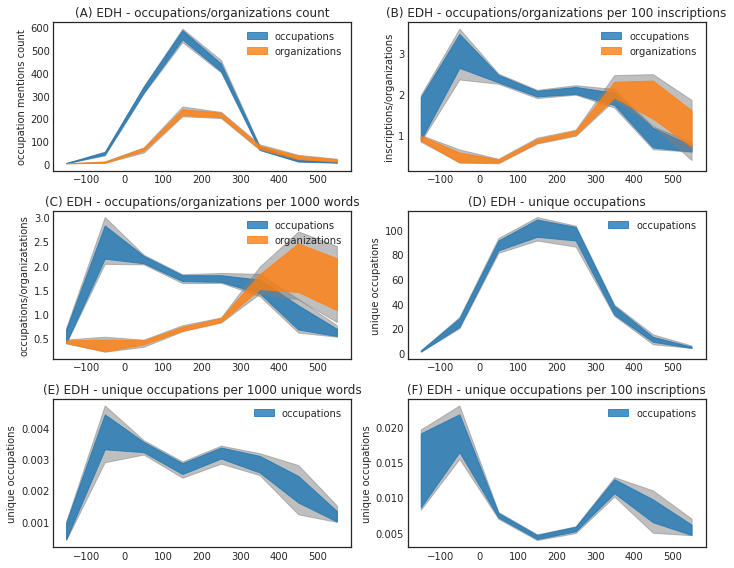

In [69]:
plt.style.use("seaborn-white")

fig, axs  = plt.subplots(3, 2, figsize=(10, 8), tight_layout=True)
n = 0
for sim_data, ax in zip(sim_data_list, axs.ravel()):
        for plot_data, color, label in zip(sim_data[0], ["tab:blue", "tab:orange"], ["occupations", "organizations"]):
            plot_timeblocks_data(plot_data, ax, color, label=label, alpha=0.8)
            n += 1
        ax.set_title(sim_data[1])
        ax.set_ylabel(sim_data[2])
        ax.legend()

In [222]:
sddk.write_file("SDAM_data/social_diversity/EDH_occupsorgs_temporal.png", fig, conf)

A file with the same name ("EDH_occupsorgs_temporal.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_temporal.png"


# Occupations & organizations by periods

In [299]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudians" : {"startdate": -27, "enddate" : 67},
    "Flavians" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 193},
    # or:
    #"5 good emperors" : {"startdate": 97, "enddate": 180},
    #"Commodus" : {"startdate" : 181, "enddate" : 193},
    "Severan dynasty" : {"startdate": 194, "enddate": 235},
    "Crisis of the 3rd\nCentury" : {"startdate" : 236, "enddate" : 284},
    "Diocetian\n& Constantine" : {"startdate" : 285, "enddate" : 337}
    }
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 67), (69, 96), (97, 193), (194, 235), (236, 284), (285, 337)]

In [300]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["occups_N"].sum()
    return occups_N_sum

def orgs_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["organizations_N"].sum()
    return occups_N_sum

In [301]:
%%time

# time consuming, apply carefully
#occups_counts = sim_data_by_function(EDH, 1000, timeblocks_periods, occups_count) 
occups_ins_ratio = sim_data_by_function(EDH, 1000, timeblocks_periods, occups_per_1K_ins)
#orgs_counts = sim_data_by_function(EDH, 1000, timeblocks_periods, orgs_count) 
orgs_ins_ratio = sim_data_by_function(EDH, 1000, timeblocks_periods, orgs_per_1K_ins)

CPU times: user 8min 41s, sys: 6.2 s, total: 8min 47s
Wall time: 8min 34s


In [302]:
occups_ins_ratio[2]

[((-27, 67), 19),
 ((69, 96), 21),
 ((97, 193), 34),
 ((194, 235), 14),
 ((236, 284), 29),
 ((285, 337), 28)]

In [303]:
def simulations_merged(simulation_data):
    merged_data = []
    for n in range(len(simulation_data[0])): # choose the first simulation to get the length 
        merged_data.append((simulation_data[0][n][0], [sim[n][1] for sim in simulation_data]))
    return merged_data

occups_ratios_merged = simulations_merged(occups_ins_ratio)
orgs_ratios_merged = simulations_merged(orgs_ins_ratio)

In [304]:
occups_ratios_merged = simulations_merged(occups_ins_ratio)
orgs_ratios_merged = simulations_merged(orgs_ins_ratio)

In [305]:
[key for key in periods.keys()]

['Julio-Claudians',
 'Flavians',
 'Nerva-Antonine',
 'Severan dynasty',
 'Crisis of the 3rd\nCentury',
 'Diocetian\n& Constantine']

In [306]:
[abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]

[94, 27, 96, 41, 48, 52]

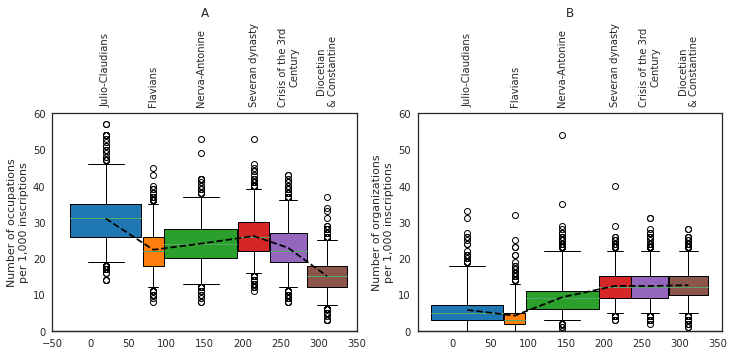

In [347]:
# number of occupations/organizizations per 1,000 randomly sampled inscriptions. The samples are with replacement. Each sample is based on different dating simulation. 

plt.style.use("seaborn-white")#-white")

labels=[key for key in periods.keys()]
widths = [abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]


fig, [ax1, ax2] = plt.subplots(1,2, figsize=[12,4])

data1 = [tup[1] for tup in occups_ratios_merged]
means1 = [np.mean(tup[1]) for tup in occups_ratios_merged]

bplot1 = ax1.boxplot(data1, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.plot(positions, means1, color="black", linestyle="dashed", zorder=10)


ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.set_ylim(0, 60)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.secondary_xaxis("bottom")
ax1.set_xlim(-50, 350)



data2 = [tup[1] for tup in orgs_ratios_merged]
means2 = [np.mean(tup[1]) for tup in orgs_ratios_merged]

bplot2 = ax2.boxplot(data2, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.plot(positions, means2, color="black", linestyle="dashed", zorder=10)

ax2.set_title("B")
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")
ax2.set_ylim(0, 60)
ax2.xaxis.set_tick_params(rotation=90)
ax2.xaxis.tick_top()
ax2.secondary_xaxis("bottom")

# fill with colors
colors =tab_colors_list[:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)